In [1]:
# importing all required pakages and libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import RobustScaler, StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error,mean_squared_log_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
import category_encoders as ce
from sklearn.feature_selection import f_regression, SelectKBest,mutual_info_regression
import xgboost
from sklearn.feature_selection import f_regression, GenericUnivariateSelect
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,KFold
from scipy.stats import zscore
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
sb.set()

### EDA and Data-preprocessing

In [2]:
ds = pd.read_excel('restaurants_Train.xlsx')
ds

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49 votes,1200
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30 votes,1500
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221 votes,800
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24 votes,800
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165 votes,300
...,...,...,...,...,...,...,...,...,...
12685,QUICK BITES,13228,"North Indian, Burger, Kebab","12noon – 12midnight (Mon, Tue, Wed, Thu, Sun)...",Hyderabad,Gachibowli,3.8,546 votes,500
12686,"CASUAL DINING,BAR",9686,"Goan, Continental","12noon – 1am (Mon-Fri),11am – 5pm, 7pm – 1am...",Mumbai,Bandra Kurla Complex,4.3,1214 votes,1800
12687,LOUNGE,11133,"Finger Food, Continental, Asian, Chinese",12noon – 12:30AM (Mon-Sun),Navi Mumbai,Vashi,4.0,608 votes,1300
12688,CASUAL DINING,6134,"North Indian, South Indian, Chinese, Street Food",6am – 10:45pm (Mon-Sun),Chennai,Maduravoyal,3.5,32 votes,400


In [3]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12690 entries, 0 to 12689
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TITLE          12690 non-null  object
 1   RESTAURANT_ID  12690 non-null  int64 
 2   CUISINES       12690 non-null  object
 3   TIME           12690 non-null  object
 4   CITY           12578 non-null  object
 5   LOCALITY       12592 non-null  object
 6   RATING         12688 non-null  object
 7   VOTES          11486 non-null  object
 8   COST           12690 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 892.4+ KB


In [4]:
ds.isnull().sum()

TITLE               0
RESTAURANT_ID       0
CUISINES            0
TIME                0
CITY              112
LOCALITY           98
RATING              2
VOTES            1204
COST                0
dtype: int64

From above tables, we have got missing values of impute.

In [5]:
# extracting numeric vote value form column 'VOTES'  
ds['VOTES'] = ds.VOTES.transform(lambda x: x.str.strip(' votes')).astype('float64')

# imputing missing values of 'VOTES'.
ds['VOTES'].fillna(ds['VOTES'].median(), inplace = True)

In [6]:
# replacing '-' and 'NEW' to NaN, and changing dtype to numeric.
ds['RATING'] = ds['RATING'].replace(['-','NEW'], np.nan)
ds['RATING'] = ds['RATING'].astype('float64')

# imputing missing values of 'RATING'.
ds['RATING'].fillna(ds['RATING'].median(), inplace = True)

In [7]:
ds[['RATING','VOTES','COST']].describe()

,RATING,VOTES,COST
count,12690.000000,12690.000000,12690.000000
mean,3.786832,391.696217,655.252246
std,0.401588,805.157717,627.003540
min,2.000000,4.000000,20.000000
25%,3.600000,64.000000,300.000000
50%,3.800000,163.000000,500.000000
75%,4.000000,405.000000,800.000000
max,4.900000,41186.000000,14000.000000


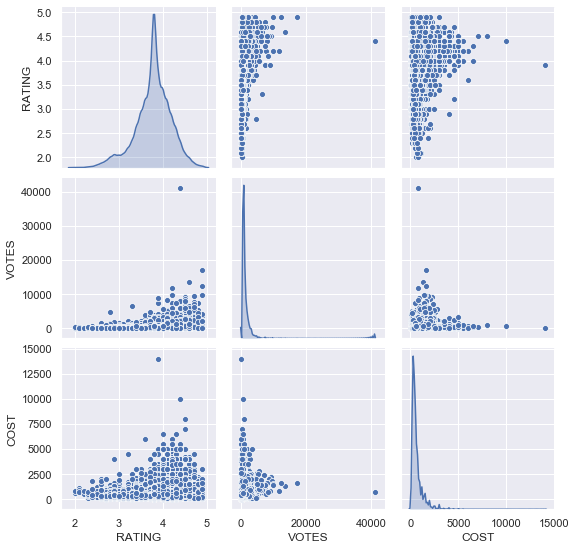

In [8]:
sb.pairplot(ds[['RATING','VOTES','COST']], diag_kind = 'kde' )

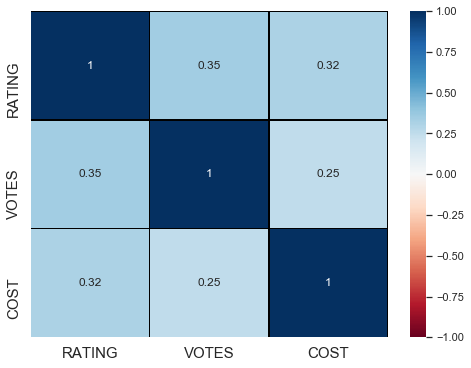

In [9]:
plt.figure(figsize = (8,6))
sb.heatmap(ds[['RATING','VOTES','COST']].corr(), cmap = 'RdBu', vmin = -1, vmax = 1, center = 0, 
           linewidth = .5, linecolor = 'black', annot = True)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

From above pairplots and heatmaps, we see cost and votes both have right skewed distributions.

We see ratings between 3-4 are most common.

Also, variables are not significantly correlated to each other.

In [10]:
ds.isnull().sum()

TITLE              0
RESTAURANT_ID      0
CUISINES           0
TIME               0
CITY             112
LOCALITY          98
RATING             0
VOTES              0
COST               0
dtype: int64

In [11]:
# imputing missing values of column 'LACALITY'
ds['LOCALITY'] = ds.groupby(['TITLE'])['LOCALITY'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [12]:
# imputing missing values of column 'CITY'
ds['CITY'] = ds.groupby(['TITLE'])['CITY'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [13]:
# splitting and expanding 'CUISINE' into different columns
ds['CUISINES'].str.split(',', expand = True)
ds[['CUISINE1','CUISINE2','CUISINE3',
'CUISINE4','CUISINE5','CUISINE6','CUISINE7','CUISINE8']] =  ds['CUISINES'].str.split(',', expand = True)

In [14]:
ds

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,CUISINE8
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200,Malwani,Goan,North Indian,None,None,None,None,None
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500,Asian,Modern Indian,Japanese,None,None,None,None,None
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221.0,800,North Indian,Chinese,Biryani,Hyderabadi,None,None,None,None
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24.0,800,Tibetan,Chinese,None,None,None,None,None,None
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165.0,300,Desserts,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12685,QUICK BITES,13228,"North Indian, Burger, Kebab","12noon – 12midnight (Mon, Tue, Wed, Thu, Sun)...",Hyderabad,Gachibowli,3.8,546.0,500,North Indian,Burger,Kebab,None,None,None,None,None
12686,"CASUAL DINING,BAR",9686,"Goan, Continental","12noon – 1am (Mon-Fri),11am – 5pm, 7pm – 1am...",Mumbai,Bandra Kurla Complex,4.3,1214.0,1800,Goan,Continental,None,None,None,None,None,None
12687,LOUNGE,11133,"Finger Food, Continental, Asian, Chinese",12noon – 12:30AM (Mon-Sun),Navi Mumbai,Vashi,4.0,608.0,1300,Finger Food,Continental,Asian,Chinese,None,None,None,None
12688,CASUAL DINING,6134,"North Indian, South Indian, Chinese, Street Food",6am – 10:45pm (Mon-Sun),Chennai,Maduravoyal,3.5,32.0,400,North Indian,South Indian,Chinese,Street Food,None,None,None,None


In [15]:
# splitting and expanding 'TITLE' into two separate columns.
ds['TITLE'].str.split(',', expand = True)
ds[['TITLE_1','TITLE_2']] = ds['TITLE'].str.split(',', expand = True)

In [16]:
ds

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES,COST,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,CUISINE8,TITLE_1,TITLE_2
0,CASUAL DINING,9438,"Malwani, Goan, North Indian","11am – 4pm, 7:30pm – 11:30pm (Mon-Sun)",Thane,Dombivali East,3.6,49.0,1200,Malwani,Goan,North Indian,None,None,None,None,None,CASUAL DINING,None
1,"CASUAL DINING,BAR",13198,"Asian, Modern Indian, Japanese",6pm – 11pm (Mon-Sun),Chennai,Ramapuram,4.2,30.0,1500,Asian,Modern Indian,Japanese,None,None,None,None,None,CASUAL DINING,BAR
2,CASUAL DINING,10915,"North Indian, Chinese, Biryani, Hyderabadi","11am – 3:30pm, 7pm – 11pm (Mon-Sun)",Chennai,Saligramam,3.8,221.0,800,North Indian,Chinese,Biryani,Hyderabadi,None,None,None,None,CASUAL DINING,None
3,QUICK BITES,6346,"Tibetan, Chinese",11:30am – 1am (Mon-Sun),Mumbai,Bandra West,4.1,24.0,800,Tibetan,Chinese,None,None,None,None,None,None,QUICK BITES,None
4,DESSERT PARLOR,15387,Desserts,11am – 1am (Mon-Sun),Mumbai,Lower Parel,3.8,165.0,300,Desserts,None,None,None,None,None,None,None,DESSERT PARLOR,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12685,QUICK BITES,13228,"North Indian, Burger, Kebab","12noon – 12midnight (Mon, Tue, Wed, Thu, Sun)...",Hyderabad,Gachibowli,3.8,546.0,500,North Indian,Burger,Kebab,None,None,None,None,None,QUICK BITES,None
12686,"CASUAL DINING,BAR",9686,"Goan, Continental","12noon – 1am (Mon-Fri),11am – 5pm, 7pm – 1am...",Mumbai,Bandra Kurla Complex,4.3,1214.0,1800,Goan,Continental,None,None,None,None,None,None,CASUAL DINING,BAR
12687,LOUNGE,11133,"Finger Food, Continental, Asian, Chinese",12noon – 12:30AM (Mon-Sun),Navi Mumbai,Vashi,4.0,608.0,1300,Finger Food,Continental,Asian,Chinese,None,None,None,None,LOUNGE,None
12688,CASUAL DINING,6134,"North Indian, South Indian, Chinese, Street Food",6am – 10:45pm (Mon-Sun),Chennai,Maduravoyal,3.5,32.0,400,North Indian,South Indian,Chinese,Street Food,None,None,None,None,CASUAL DINING,None


In [17]:
# droping features that have been already extracted.
ds.drop(['TITLE','CUISINES','TIME','RESTAURANT_ID'],1, inplace = True)

In [18]:
for col in  list(ds.select_dtypes(include = 'O')):
    print(col,'\n', ds[col].value_counts())
    print('--------------------------------------------')  

CITY 
 Chennai                        2199
Bangalore                      2156
Hyderabad                      1819
Mumbai                         1723
New Delhi                      1400
                               ... 
Janakpuri                         1
opp mukteshwar ashram powai       1
Navi Mumbai.                      1
Mulund East                       1
Fort Kochi                        1
Name: CITY, Length: 359, dtype: int64
--------------------------------------------
LOCALITY 
 Gachibowli          246
Indiranagar         144
Edappally           123
Kakkanad            121
HSR                 120
                   ... 
Eri Scheme            1
Road 37               1
New Tippasandra       1
Ballabhgarh           1
near swarn nagri      1
Name: LOCALITY, Length: 1416, dtype: int64
--------------------------------------------
CUISINE1 
 North Indian    3129
South Indian    1241
Chinese          996
Fast Food        762
Cafe             713
                ... 
Hot dogs      

From above data, we see all columns having categories that have unique values of one, to which we shall group to different categories.

In [19]:
ds

,CITY,LOCALITY,RATING,VOTES,COST,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,CUISINE8,TITLE_1,TITLE_2
0,Thane,Dombivali East,3.6,49.0,1200,Malwani,Goan,North Indian,None,None,None,None,None,CASUAL DINING,None
1,Chennai,Ramapuram,4.2,30.0,1500,Asian,Modern Indian,Japanese,None,None,None,None,None,CASUAL DINING,BAR
2,Chennai,Saligramam,3.8,221.0,800,North Indian,Chinese,Biryani,Hyderabadi,None,None,None,None,CASUAL DINING,None
3,Mumbai,Bandra West,4.1,24.0,800,Tibetan,Chinese,None,None,None,None,None,None,QUICK BITES,None
4,Mumbai,Lower Parel,3.8,165.0,300,Desserts,None,None,None,None,None,None,None,DESSERT PARLOR,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12685,Hyderabad,Gachibowli,3.8,546.0,500,North Indian,Burger,Kebab,None,None,None,None,None,QUICK BITES,None
12686,Mumbai,Bandra Kurla Complex,4.3,1214.0,1800,Goan,Continental,None,None,None,None,None,None,CASUAL DINING,BAR
12687,Navi Mumbai,Vashi,4.0,608.0,1300,Finger Food,Continental,Asian,Chinese,None,None,None,None,LOUNGE,None
12688,Chennai,Maduravoyal,3.5,32.0,400,North Indian,South Indian,Chinese,Street Food,None,None,None,None,CASUAL DINING,None


In [20]:
ds.isnull().sum()

CITY            0
LOCALITY        0
RATING          0
VOTES           0
COST            0
CUISINE1        0
CUISINE2     3062
CUISINE3     6999
CUISINE4     9995
CUISINE5    11675
CUISINE6    12276
CUISINE7    12514
CUISINE8    12613
TITLE_1         0
TITLE_2     11208
dtype: int64

In [21]:
# replacing 'None' values of extracted features to zero.
ds = ds.fillna(0)

In [22]:
# grouping categories having unique values less then 5 into 'other' group.
for col in  list(ds.select_dtypes(include = 'O')):
    group = list(ds[col].value_counts()[ds[col].value_counts() < 5].index)
    ds[col] = ds[col].apply(lambda x :'Other' if x in group 
                                     else x)

In [23]:
for col in  list(ds.select_dtypes(include = 'O')):
    print(col,'\n', ds[col].value_counts())
    print('--------------------------------------------')  

CITY 
 Chennai          2199
Bangalore        2156
Hyderabad        1819
Mumbai           1723
New Delhi        1400
Kochi            1279
Other             384
Gurgaon           379
Secunderabad      310
Noida             211
Navi Mumbai       165
Ghaziabad         102
Thane              97
Faridabad          79
Bandra West        69
Thane West         52
Andheri West       48
Bengaluru          42
Greater Noida      31
India              23
Kakkanad           15
Ernakulam          14
Dwarka             10
Kerala             10
Delhi NCR           9
Delhi               8
Telangana           7
Gurugram            7
Edappally           7
Hyderabad.          7
Bengalore           6
Jubilee Hills       6
Madhapur            6
Tamil Nadu          5
Maharashtra         5
Name: CITY, dtype: int64
--------------------------------------------
LOCALITY 
 Other             1266
Gachibowli         246
Indiranagar        144
Edappally          123
Kakkanad           121
                  ... 
DLF 

In [24]:
ds

,CITY,LOCALITY,RATING,VOTES,COST,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,CUISINE8,TITLE_1,TITLE_2
0,Thane,Dombivali East,3.6,49.0,1200,Malwani,Goan,North Indian,0,0,0,0,0,CASUAL DINING,0
1,Chennai,Ramapuram,4.2,30.0,1500,Asian,Modern Indian,Japanese,0,0,0,0,0,CASUAL DINING,BAR
2,Chennai,Saligramam,3.8,221.0,800,North Indian,Chinese,Biryani,Hyderabadi,0,0,0,0,CASUAL DINING,0
3,Mumbai,Bandra West,4.1,24.0,800,Tibetan,Chinese,0,0,0,0,0,0,QUICK BITES,0
4,Mumbai,Lower Parel,3.8,165.0,300,Desserts,0,0,0,0,0,0,0,DESSERT PARLOR,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12685,Hyderabad,Gachibowli,3.8,546.0,500,North Indian,Burger,Kebab,0,0,0,0,0,QUICK BITES,0
12686,Mumbai,Bandra Kurla Complex,4.3,1214.0,1800,Goan,Continental,0,0,0,0,0,0,CASUAL DINING,BAR
12687,Navi Mumbai,Vashi,4.0,608.0,1300,Finger Food,Continental,Asian,Chinese,0,0,0,0,LOUNGE,0
12688,Chennai,Maduravoyal,3.5,32.0,400,North Indian,South Indian,Chinese,Street Food,0,0,0,0,CASUAL DINING,0


In [25]:
# Here, we are trying to tune the smoothing parameter using cross validation on training-set.
# this is usually done to prevent the mean/target encoded data to overfit the training set. 

x_train, x_test, y_train, y_test = train_test_split(ds.drop(['COST'], 1), 
                                                    ds.COST,
                                                test_size = 0.30, random_state = 42) 
score_list = []
smoothing_list = np.arange(0,5,.125)
model  =  xgboost.XGBRegressor(silent = True) # using xgboost model for tuning smoothing parameter.
for num in smoothing_list:
    x_train_en = x_train.copy()
    
    for col in list(ds.select_dtypes(include = 'O')):
        

        encoder =  ce.TargetEncoder(cols = col, smoothing = num)
        x_train_en[col] = encoder.fit_transform(x_train_en[col], y_train)
    score = cross_val_score(model, x_train_en, y_train, cv = 10, scoring = 'r2', n_jobs = -1 ).mean()
    score_list.append(score)
        
print('Optimum cross-val-score:',max(score_list),
      'corresponds to smoothing value of:',smoothing_list[score_list.index(max(score_list))])    

Optimum cross-val-score: 0.768252606879442 corresponds to smoothing value of: 4.0


In [26]:
# train-test split
x_train, x_test, y_train, y_test = train_test_split(ds.drop(['COST'], 1), 
                                                    ds.COST,
                                                test_size = 0.30, random_state = 42) 

In [27]:
x_train_copy = x_train.copy() # copying x_train for later use.

In [28]:
# target encoding features  using tuned smoothing value.
for col in list(ds.select_dtypes(include = 'O')):
    
        encoder =  ce.TargetEncoder(cols = col, smoothing =   4)
        x_train[col] = encoder.fit_transform(x_train[col], y_train)
        x_test[col] = encoder.transform(x_test[col])

In [29]:
# robsut scaling numeric data.
for col in ['RATING','VOTES']:
    
    scaler = RobustScaler()
    x_train[col] = scaler.fit_transform(x_train[col].values.reshape(-1,1))
    x_test[col] = scaler.transform(x_test[col].values.reshape(-1,1))

In [30]:
# feature selection using SelectKBest
selector = SelectKBest(mutual_info_regression)
selector.fit(x_train, y_train)

SelectKBest(score_func=<function mutual_info_regression at 0x0000027FF342A558>)

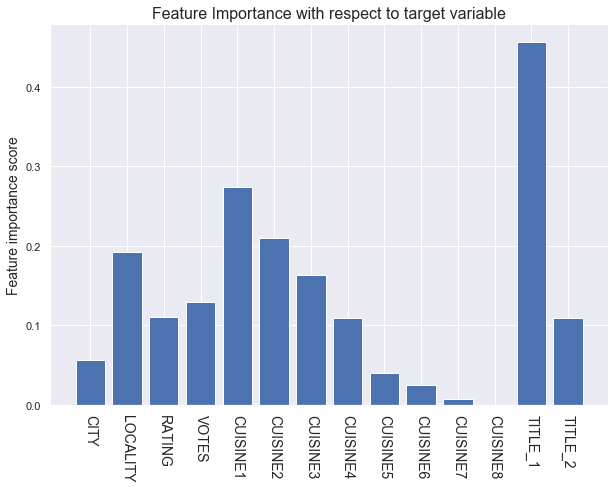

In [31]:
# plotting  the scores
plt.figure(figsize = (10,7))
plt.bar(x_train.columns, selector.scores_)
plt.xticks(rotation = -90, fontsize = 14)
plt.title('Feature Importance with respect to target variable', fontsize = 16)
plt.ylabel('Feature importance score', fontsize = 14)
plt.show()

From above plot, we see that Title 1 is the most important feature followed cuisine 1,2 and Locality, for prediction of food price.

In [32]:
selector = pd.DataFrame(dict(Feature = list(x_train.columns), Scores = selector.scores_))
selector.sort_values(by = 'Scores', ascending = False ).head(30)

,Feature,Scores
12,TITLE_1,0.456177
4,CUISINE1,0.274015
5,CUISINE2,0.210086
1,LOCALITY,0.192807
6,CUISINE3,0.163470
3,VOTES,0.129910
2,RATING,0.111015
13,TITLE_2,0.109636
7,CUISINE4,0.109112
0,CITY,0.056638


In [33]:
# keeping features with scores above threshold score.
threshold = 0
selected_features = selector[selector.Scores > threshold]
selected_features.sort_values(by = 'Scores', ascending = False )

,Feature,Scores
12,TITLE_1,0.456177
4,CUISINE1,0.274015
5,CUISINE2,0.210086
1,LOCALITY,0.192807
6,CUISINE3,0.163470
3,VOTES,0.129910
2,RATING,0.111015
13,TITLE_2,0.109636
7,CUISINE4,0.109112
0,CITY,0.056638


In [34]:
print('no. of selected features:', len(selected_features))

no. of selected features: 13


In [35]:
# selecting highest scoring features for train and test set.
x_train_red = x_train[list(selected_features['Feature'])]
x_test_red = x_test[list(selected_features['Feature'])]

In [36]:
x_train_red.shape, x_test_red.shape

((8883, 13), (3807, 13))

In [37]:
x_train_red

,CITY,LOCALITY,RATING,VOTES,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,TITLE_1,TITLE_2
12473,1344.960066,1654.337144,0.75,1.938416,720.949568,850.539568,543.724286,594.170323,634.669844,648.671324,656.337061,830.352881,611.362813
7476,538.843866,583.544743,-1.25,-0.111437,403.135690,531.451311,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813
7229,588.345515,412.542195,-0.25,0.073314,403.135690,958.200000,703.492885,594.170323,634.669844,648.671324,656.337061,830.352881,611.362813
7581,679.452054,583.544743,0.00,-0.249267,687.546362,1001.265822,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813
3148,869.645799,742.727159,0.00,0.032258,720.949568,544.810127,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,691.592920,969.248355,1.50,0.709677,720.949568,1234.474474,846.362820,1150.000000,634.669844,648.671324,656.337061,1493.823529,1397.222222
5191,688.972167,453.322374,1.50,2.563050,720.949568,850.539568,543.724286,594.170323,634.669844,648.671324,656.337061,830.352881,611.362813
5390,688.972167,805.952381,0.00,-0.290323,720.949568,643.728043,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813
860,538.843866,308.650546,0.00,0.000000,318.230769,295.891018,543.724286,594.170323,634.669844,648.671324,656.337061,262.635135,611.362813


In [38]:
k =  KFold(n_splits = 10)

model: RandomForestRegressor()
CV score:0.7610800528989295
score_std: 0.05493209633756543
----------
model: LinearRegression(normalize=True)
CV score:0.7269419852701577
score_std: 0.05304569696932395
----------
model: SVR()
CV score:0.38180798898469076
score_std: 0.05218169219834745
----------
model: AdaBoostRegressor()
CV score:0.38692596087111186
score_std: 0.15417590269420883
----------
model: GradientBoostingRegressor()
CV score:0.7637084217469547
score_std: 0.0537729380879498
----------
model: KNeighborsRegressor()
CV score:0.7181960547781013
score_std: 0.05327781920104153
----------
model: XGBRegressor(silent=True)
CV score:0.7677933127639717
score_std: 0.05418900758317112
----------
model: Lasso(normalize=True)
CV score:0.6860351561939121
score_std: 0.0577412051447029
----------
model: Ridge(normalize=True)
CV score:0.6412705555806189
score_std: 0.0680230455694943
----------
model: ElasticNet()
CV score:0.7266366643943595
score_std: 0.05305712123790611
----------
model: Decision

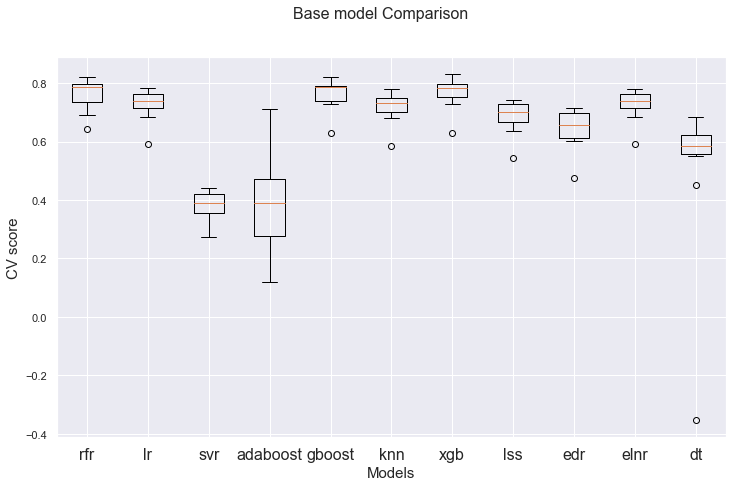

In [39]:
# inilializing different models
rfr = RandomForestRegressor()
svr = SVR()
lr = LinearRegression(normalize = True)
adaboost =  AdaBoostRegressor()
gboost = GradientBoostingRegressor()
knn = KNeighborsRegressor()
xgb = xgboost.XGBRegressor(silent = True)
lss = Lasso(normalize = True)
rdr = Ridge(normalize = True)
elnr = ElasticNet()
dt = DecisionTreeRegressor()

models = [rfr, lr, svr, adaboost, gboost, knn, xgb, lss, rdr, elnr, dt]

scores = []
for model in models:
    
    score = cross_val_score(model, x_train_red, y_train, cv = k, scoring = 'r2', n_jobs = -1 )
    mean_score = score.mean()
    std_score = score.std()
    
    print('model: {}'.format(model))
    print('CV score:{}'.format(mean_score))
    print('score_std:',std_score)
    print('----------')
    scores.append(score)
    
fig = plt.figure()
fig.suptitle('Base model Comparison', fontsize = 16)
ax = fig.add_subplot(111)
plt.boxplot(scores)
ax.set_xticklabels(['rfr', 'lr','svr', 'adaboost', 'gboost', 'knn', 'xgb','lss','edr','elnr','dt'],
                  fontsize = 16)
plt.xlabel('Models', fontsize = 15)
plt.ylabel('CV score', fontsize = 15)
fig.set_size_inches(12,7)
plt.show() 

Based on  above cross-val-scores and boxplots, except for svr and adaboost, we select all models for tuning.

### Hyper-parameter tuning

In [40]:
# initializing parameters for each models for model-tuning.
param_gboost =  dict(
    learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5],
    max_depth = [ 2,3, 4, 5, 6,7, 8],
    n_estimators = [100, 150, 200,250,300],
    min_samples_split = [1,2,3], random_state = [40,41,42,43,44],
    alpha = [0.05,0.1,0.5,0.75,1,1.75,2])

param_rfr = dict(n_estimators = [10,15,20,25,30], criterion = ['mse', 'mae'],
                max_depth = [3,4,5,6,7,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [40,41,42,43,44])

  
param_xgb = dict( learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
     max_depth = [ 3, 4, 5, 6, 8, 10, 12, 15],
     min_child_weight = [ 1, 3, 5, 7 ],
     gamma = [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     colsample_bytree = [ 0.3, 0.4, 0.5 , 0.7 ],
     alpha = [0.05,0.1,0.5,0.75,1,1.75,2]
     )

param_elnr = dict(alpha = np.arange(0.05,2, 0.05), l1_ratio = np.arange(0.05,1, 0.01),
                 normalize = [True, False], selection = ['cyclic', 'random'])

param_rdr = dict(alpha = np.arange(0.05,2, 0.05), solver = ['svd', 
         'cholesky','lsqr','sparse_cg','sag','saga'])

param_knn = dict(n_neighbors = np.arange(1,20,1), weights = ['uniform','distance'],
                algorithm = ['auto', 'all_tree', 'kd_tree', 'brute'])

param_lss = dict(alpha = np.arange(0.05,2, 0.05), selection = ['cyclic', 'random'])

param_dt = dict(splitter = ['best', 'random'], criterion = ['mse', 'friedman_mse', 'mae'],
                max_depth = [3,4,5,6,7,8,None],min_samples_split = [2,3,4],
                min_samples_leaf = [1,2,3], random_state = [40,41,42,43,44]
                )

In [41]:
model_param_list = [(gboost,param_gboost),(rfr,param_rfr), (xgb,param_xgb), (elnr,param_elnr),
                   (knn, param_knn),(dt,param_dt), (rdr, param_rdr),(lss, param_lss)]

In [42]:
%%time
best_estimator_list = []
for model, param in model_param_list:
    
    r_rearch = RandomizedSearchCV(model, param, cv = k, n_jobs = -1, scoring = 'neg_root_mean_squared_error',
                                  random_state = 42)
    r_rearch.fit( x_train_red, y_train.values.ravel())
    best_cvscore = r_rearch.best_score_
    best_param = r_rearch.best_params_
    best_estimator = r_rearch.best_estimator_
    best_estimator_list.append(best_estimator)
    
    print('model:',model)
    print('best_cvscore:',best_cvscore)
    print('best_param:', best_param)
    print('\n')
    
print('best_estimators:',best_estimator_list)

model: GradientBoostingRegressor()
best_cvscore: -313.5293212664943
best_param: {'random_state': 44, 'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.05, 'alpha': 0.75}


model: RandomForestRegressor()
best_cvscore: -310.2285587967914
best_param: {'random_state': 44, 'n_estimators': 25, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': None, 'criterion': 'mse'}


model: XGBRegressor(silent=True)
best_cvscore: -307.86697340249816
best_param: {'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.0, 'colsample_bytree': 0.7, 'alpha': 1.75}


model: ElasticNet()
best_cvscore: -335.1293249373974
best_param: {'selection': 'cyclic', 'normalize': False, 'l1_ratio': 0.26000000000000006, 'alpha': 0.1}


model: KNeighborsRegressor()
best_cvscore: -327.3783912854809
best_param: {'weights': 'uniform', 'n_neighbors': 14, 'algorithm': 'auto'}


model: DecisionTreeRegressor()
best_cvscore: -338.59041240781437
best_param: {'splitter': 'best', '

In [43]:
best_estimator_list.append(lr) # appending linear regression model for testing.

In [44]:
# testing for train data
print('****TRAIN RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_train_red)
    score = r2_score(y_train, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_train, y_pred, squared = False))
    print('-------------------------------------------')

****TRAIN RESULTS****


model GradientBoostingRegressor(alpha=0.75, learning_rate=0.05, max_depth=5,
                          n_estimators=150, random_state=44)
accuracy (r2_score): 88.56 %
root_mean_squared_error: 217.31762831841746
-------------------------------------------
model RandomForestRegressor(min_samples_leaf=3, n_estimators=25, random_state=44)
accuracy (r2_score): 90.17 %
root_mean_squared_error: 201.40155545486977
-------------------------------------------
model XGBRegressor(alpha=1.75, colsample_bytree=0.7, gamma=0.0, max_depth=4,
             min_child_weight=5, silent=True)
accuracy (r2_score): 83.8 %
root_mean_squared_error: 258.575222220574
-------------------------------------------
model ElasticNet(alpha=0.1, l1_ratio=0.26000000000000006)
accuracy (r2_score): 72.07 %
root_mean_squared_error: 339.4970828014561
-------------------------------------------
model KNeighborsRegressor(n_neighbors=14)
accuracy (r2_score): 77.05 %
root_mean_squared_error: 307.78155298409

In [45]:
# testing for test data
print('****TEST RESULTS****')
print('\n')

for model in best_estimator_list:
    model.fit(x_train_red, y_train)
    y_pred = model.predict(x_test_red)
    score = r2_score(y_test, y_pred)
    print('model',model)
    print('accuracy (r2_score):',  round(score*100,2),'%')
    print('root_mean_squared_error:',mean_squared_error(y_test, y_pred, squared = False))
    print('-------------------------------------------')

****TEST RESULTS****


model GradientBoostingRegressor(alpha=0.75, learning_rate=0.05, max_depth=5,
                          n_estimators=150, random_state=44)
accuracy (r2_score): 76.67 %
root_mean_squared_error: 284.57821915459925
-------------------------------------------
model RandomForestRegressor(min_samples_leaf=3, n_estimators=25, random_state=44)
accuracy (r2_score): 76.55 %
root_mean_squared_error: 285.3327120212329
-------------------------------------------
model XGBRegressor(alpha=1.75, colsample_bytree=0.7, gamma=0.0, max_depth=4,
             min_child_weight=5, silent=True)
accuracy (r2_score): 76.07 %
root_mean_squared_error: 288.24558032312694
-------------------------------------------
model ElasticNet(alpha=0.1, l1_ratio=0.26000000000000006)
accuracy (r2_score): 72.82 %
root_mean_squared_error: 307.1744293945743
-------------------------------------------
model KNeighborsRegressor(n_neighbors=14)
accuracy (r2_score): 73.58 %
root_mean_squared_error: 302.8384742014

From above train and test results, we shall select GradientBoostingRegressor model, as it has the highest r2 score and lowest root mean squared error. 

In [46]:
# selecting best model as GradientBoostingRegressor
selected_model = GradientBoostingRegressor(alpha=0.75, learning_rate=0.05, max_depth=5,
                          n_estimators=150, random_state=44)

selected_model.fit(x_train_red, y_train)

y_pred = selected_model.predict(x_test_red)

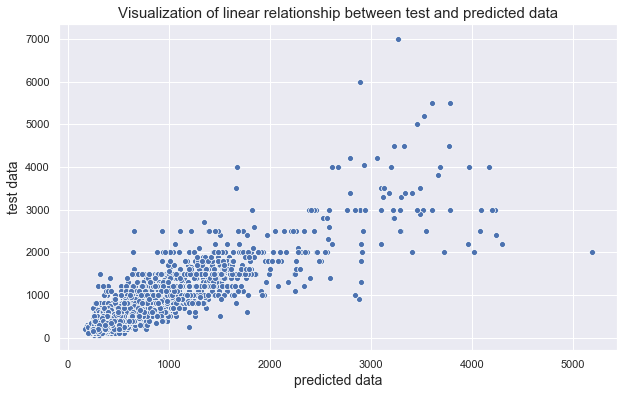

In [47]:
plt.figure(figsize = (10,6))
sb.scatterplot(y_pred,y_test )
plt.xlabel('predicted data', fontsize = 14)
plt.ylabel('test data',  fontsize = 14)
plt.title('Visualization of linear relationship between test and predicted data',fontsize = 15 )
plt.show()

From above scatterplot, although the points gets scattered widely for higher values, we see that predicted and test data somewhat follows a linear relationship.

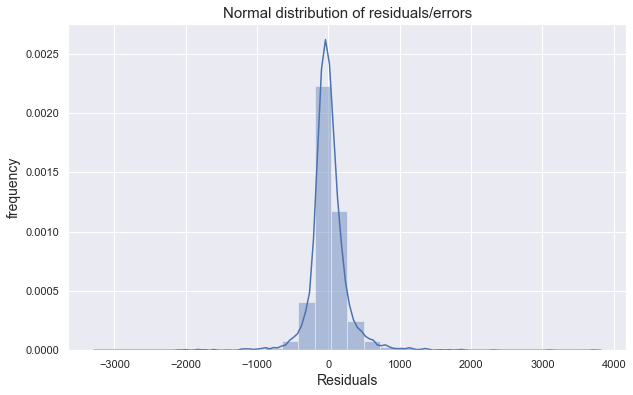

In [48]:
plt.figure(figsize = (10,6))
sb.distplot((y_test-y_pred), bins = 30)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('frequency',  fontsize = 14)
plt.title('Normal distribution of residuals/errors',fontsize = 15 )
plt.show()

From above distplot, that residuals of the model is very close to that of a normal distribution, with mean approximately close to zero

In [49]:
test_df = pd.DataFrame({'Actual price':y_test.values,'Predicted price':y_pred})

In [50]:
test_df.to_csv('food_price_pred.csv', index = False)
print('Predicted result stored sucessfully.')

Predicted result stored sucessfully.


In [51]:
# Saving the final model as GradientBoostingRegressor.
import joblib

joblib.dump(selected_model, 'food_price_pred.obj')
print('Model successfully saved.')

Model successfully saved.


### Data-preprocessing of test dataset for prediction

In [52]:
test = pd.read_excel('restaurants_Test.xlsx')
test

,TITLE,RESTAURANT_ID,CUISINES,TIME,CITY,LOCALITY,RATING,VOTES
0,CASUAL DINING,4085,"North Indian, Chinese, Mughlai, Kebab",12noon – 12midnight (Mon-Sun),Noida,Sector 18,4.3,564 votes
1,QUICK BITES,12680,"South Indian, Fast Food, Pizza, North Indian",7am – 12:30AM (Mon-Sun),Mumbai,Grant Road,4.2,61 votes
2,CASUAL DINING,1411,"North Indian, Seafood, Biryani, Chinese",11am – 11:30pm (Mon-Sun),Mumbai,Marine Lines,3.8,350 votes
3,None,204,Biryani,"9am – 10pm (Mon, Wed, Thu, Fri, Sat, Sun), 10:...",Faridabad,NIT,3.8,1445 votes
4,QUICK BITES,13453,"South Indian, Kerala",11am – 10pm (Mon-Sun),Kochi,Kaloor,3.6,23 votes
...,...,...,...,...,...,...,...,...
4226,CASUAL DINING,9057,"North Indian, Mughlai, Chinese",11:30am – 11:30pm (Mon-Sun),New Delhi,Punjabi Bagh,3.9,287 votes
4227,None,1247,"Biryani, North Indian, Sandwich, Salad, Wraps",11am – 1am (Mon-Sun),Bangalore,HSR Layout,4.3,469 votes
4228,QUICK BITES,8617,"Continental, North Indian",9:30am – 10:30pm (Mon-Sun),Faridabad,Sector 86,3.7,53 votes
4229,QUICK BITES,6485,"Rolls, Beverages","11am – 11:30pm (Mon, Tue, Wed, Thu, Sat, Sun),...",Kochi,Kochi,-,NaN


In [53]:
test.isnull().sum()

TITLE              0
RESTAURANT_ID      0
CUISINES           0
TIME               0
CITY              35
LOCALITY          30
RATING             2
VOTES            402
dtype: int64

In [54]:
# extracting numeric vote value form column 'VOTES'  
test['VOTES'] = test.VOTES.transform(lambda x: x.str.strip(' votes')).astype('float64')

# imputing missing values of 'VOTES'.
test['VOTES'].fillna(test['VOTES'].median(), inplace = True)

In [55]:
# replacing '-' and 'NEW' to NaN, and changing dtype to numeric.
test['RATING'] = test['RATING'].replace(['-','NEW'], np.nan)
test['RATING'] = test['RATING'].astype('float64')

# imputing missing values of 'RATING'.
test['RATING'].fillna(test['RATING'].median(), inplace = True)

In [56]:
# imputing missing values of column 'LACALITY'
test['LOCALITY'] = test.groupby(['TITLE'])['LOCALITY'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [57]:
# imputing missing values of column 'CITY'
test['CITY'] = test.groupby(['TITLE'])['CITY'].transform(lambda x:
                                         x.fillna(x.mode()[0]))

In [58]:
# splitting and expanding 'CUISINE' into different columns
test['CUISINES'].str.split(',', expand = True)
test[['CUISINE1','CUISINE2','CUISINE3',
'CUISINE4','CUISINE5','CUISINE6','CUISINE7','CUISINE8']] =  test['CUISINES'].str.split(',', expand = True)

In [59]:
# splitting and expanding 'TITLE' into two separate columns.
test['TITLE'].str.split(',', expand = True)
test[['TITLE_1','TITLE_2']] = test['TITLE'].str.split(',', expand = True)

In [60]:
# droping features that have been already extracted.
test.drop(['TITLE','CUISINES','TIME','RESTAURANT_ID'],1, inplace = True)

In [61]:
# replacing 'None' values of extracted features to zero.
test = test.fillna(0)

In [62]:
# grouping categories having unique values less then 5 into 'other' group.
for col in  list(test.select_dtypes(include = 'O')):
    group = list(test[col].value_counts()[test[col].value_counts() < 5].index)
    test[col] = test[col].apply(lambda x :'Other' if x in group 
                                     else x)

In [63]:
# target encoding features  using tuned smoothing value.
for col in list(ds.select_dtypes(include = 'O')):
    
        encoder =  ce.TargetEncoder(cols = col, smoothing =   4)
        x_train_copy[col] = encoder.fit_transform(x_train_copy[col], y_train)
        test[col] = encoder.transform(test[col])

In [64]:
# robsut scaling numeric data.
for col in ['RATING','VOTES']:
    
    scaler = RobustScaler()
    x_train_copy[col] = scaler.fit_transform(x_train_copy[col].values.reshape(-1,1))
    test[col] = scaler.transform(test[col].values.reshape(-1,1))

In [65]:
# feature selection for test dataset.
test = test[list(selected_features['Feature'])]

In [66]:
test

,CITY,LOCALITY,RATING,VOTES,CUISINE1,CUISINE2,CUISINE3,CUISINE4,CUISINE5,CUISINE6,CUISINE7,TITLE_1,TITLE_2
0,655.298013,930.341219,1.25,1.175953,720.949568,643.728043,766.048387,691.461983,634.669844,648.671324,656.337061,830.352881,611.362813
1,869.645799,534.326948,1.00,-0.299120,403.135690,400.224719,779.660957,1034.892086,634.669844,648.671324,656.337061,346.779051,611.362813
2,869.645799,583.544743,0.00,0.548387,720.949568,958.200000,571.727749,872.488038,634.669844,648.671324,656.337061,830.352881,611.362813
3,486.727510,333.183938,0.00,3.759531,451.836158,531.451311,543.724286,594.170323,634.669844,648.671324,656.337061,418.321168,611.362813
4,432.052402,295.161377,-0.50,-0.410557,403.135690,572.968763,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4226,776.270000,715.868632,0.25,0.363636,720.949568,850.539568,703.492885,594.170323,634.669844,648.671324,656.337061,830.352881,611.362813
4227,688.972167,583.544743,1.25,0.897361,451.836158,675.156576,437.865242,1392.029754,659.922098,648.671324,656.337061,418.321168,611.362813
4228,486.727510,583.544743,-0.25,-0.322581,1303.284932,675.156576,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813
4229,432.052402,639.479324,0.00,0.008798,311.855641,364.150943,543.724286,594.170323,634.669844,648.671324,656.337061,346.779051,611.362813


In [67]:
# loading  object file of the model for predicting test dataset.
model = joblib.load('food_price_pred.obj')

In [68]:
y_test_pred = model.predict(test)

In [69]:
test_2 = pd.DataFrame({'Pedicted price':y_test_pred})

In [70]:
test_2.to_csv('food_price_test_pred.csv', index = False)
print('Predicted result of test data  stored sucessfully.')

Predicted result of test data  stored sucessfully.
